In [35]:
import numpy as np
from matplotlib import pyplot as plt
from math import exp, cos, sin, sqrt, atan2


In [ ]:
ke = 200
ex = np.zeros(ke)
dx = np.zeros(ke)
ix = np.zeros(ke)
hy = np.zeros(ke)

ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size

number_of_frequencies = 3
freq = np.array((500e6, 200e6, 100e6))
t0 = 50
spread = 10
boundary_low = [0, 0]
boundary_high = [0, 0]

# Create Dielectric Profile
epsz = 8.854e-12
epsr = 4
sigma = 0
k_start = 100

gax = np.ones(ke)
gbx = np.zeros(ke)
gax[k_start:] = 1 / (epsr + (sigma * dt / epsz))
gbx[k_start:] = sigma * dt / epsz

# To be used in the Fourier transform
arg = 2 * np.pi * freq * dt
real_pt = np.zeros((number_of_frequencies, ke))
imag_pt = np.zeros((number_of_frequencies, ke))
real_in = np.zeros(number_of_frequencies)
imag_in = np.zeros(number_of_frequencies)
amp_in = np.zeros(number_of_frequencies)
phase_in = np.zeros(number_of_frequencies)
amp = np.zeros((number_of_frequencies, ke))
phase = np.zeros((number_of_frequencies, ke))

nsteps = 400

# Dictionary to keep track of desired points for plotting
plotting_points = [
    {'num_steps': 200, 'ex': None, 'amp': None, 'phase': None, 'label': '', 'label_ab': '(a)'},
    {'num_steps': 400, 'ex': None, 'amp': None, 'phase': None, 'label': 'FDTD cells', 'label_ab': '(b)'}
]


In [37]:

# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate Dx
    for k in range(1, ke):
        dx[k] = dx[k] + 0.5 * (hy[k - 1] - hy[k])
        
    # Put a sinusoidal at the low end
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    dx[5] = pulse + dx[5]
    
    # Calculate the Ex field from Dx
    for k in range(1, ke):
        ex[k] = gax[k] * (dx[k] - ix[k])
        ix[k] = ix[k] + gbx[k] * ex[k]
    # Calculate the Fourier transform of Ex
    for k in range(ke):
        for m in range(number_of_frequencies):
            real_pt[m, k] = real_pt[m, k] + cos(arg[m]* time_step) * ex[k]
            imag_pt[m, k] = imag_pt[m, k] - sin(arg[m]* time_step) * ex[k]
    # Fourier Transform of the input pulse
    if time_step < 100:
        for m in range(number_of_frequencies):
            real_in[m] = real_in[m] + cos(arg[m] * time_step) * ex[10]
            imag_in[m] = imag_in[m] - sin(arg[m] * time_step) * ex[10]
            
    # Absorbing Boundary Conditions
    ex[0] = boundary_low.pop(0)
    boundary_low.append(ex[1])
    
    ex[ke - 1] = boundary_high.pop(0)
    boundary_high.append(ex[ke - 2])
    
    # Calculate the Hy field
    for k in range(ke - 1):
        hy[k] = hy[k] + 0.5 * (ex[k] - ex[k + 1])
        
    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            # Calculate the amplitude and phase at each freq
            for m in range(number_of_frequencies):
                amp_in[m] = sqrt(imag_in[m] ** 2 + real_in [m]** 2)
                phase_in[m] = atan2(imag_in[m], real_in[m])
                for k in range(ke):
                    amp[m, k] = (1 / amp_in[m]) * sqrt((real_pt[m, k]) ** 2 + (imag_pt[m, k])** 2)
                    phase[m, k] = atan2(imag_pt[m, k], real_pt[m, k]) - phase_in[m]
            plotting_point['ex'] = np.copy(ex)
            plotting_point['amp'] = np.copy(amp)
            plotting_point['phase'] = np.copy(phase)

In [ ]:
def plot_e_field(data, ga, timestep, label_ab):
    """Plot of E field at a single time step"""
    plt.plot(data, color='k', linewidth=1)
    plt.ylabel('E$_x$', fontsize='14')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 199)
    plt.yticks((-1, 0, 1))
    plt.ylim(-1.2, 1.2)
    plt.text(35, 0.3, 'Time Domain, T = {}'.format(timestep), horizontalalignment='center')
    plt.plot(-(ga - 1) / 0.75, 'k--', linewidth=0.75) # The math on gb is just for scaling
    plt.text(-25, -2.1, label_ab, horizontalalignment='center')
    return

def plot_amp(data, ga, freq, label):
    """ Plot of the Fourier transform amplitude at a single time step"""
    plt.plot(data[0], color='k', linewidth=1)
    plt.ylabel('Amp')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 199)
    plt.yticks(np.arange(0, 1.9, step=1))
    plt.ylim(0, 1.9)
    plt.text(150, 1.2,
                'Freq. Domain at {} MHz'.format(int(round
                (freq[0] / 1e6))),
                horizontalalignment='center')
    plt.plot(-(ga - 1) / 0.75, 'k--',
            linewidth=0.75) # The math on gb is just for scaling
    plt.xlabel('{}'.format(label))
    return


<Figure size 800x700 with 0 Axes>

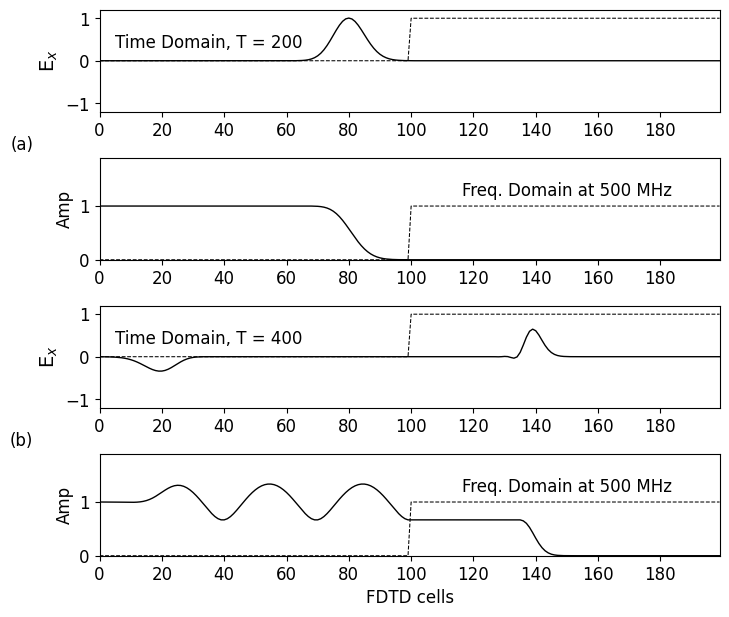

In [40]:
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(8, 7))

# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(4, 1, subplot_num * 2 + 1)
    plot_e_field(
        plotting_point['ex'],
        gax,
        plotting_point['num_steps'],
        plotting_point['label_ab']
    )
    ax = fig.add_subplot(4, 1, subplot_num * 2 + 2)
    plot_amp(
        plotting_point['amp'],
        gax,
        freq,
        plotting_point['label'],
    )
    
plt.subplots_adjust(bottom=0.1, hspace=0.45)
plt.show()